# Plots - BS, DOS, pDOS, QE, MTE, Murnaghan EOS, Convergence

In [1]:
import subprocess
import os
from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep
import pandas as pd


from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from python_functions import *
from bs_plotting import *
from castep_output_class import *
from optados_output_class import *
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from python_functions import *
from calculation_class import *
#from ../../modules_codes/script_share/python/bs_plotter_felix_mod import *


### General Viewing

In [2]:
filename = './OD_debug_files/Cu100/Cu100_od_rerun_geometry.cell'
structure = read_cell2pmg(filename)
view(AseAtomsAdaptor.get_atoms(structure))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [2]:
filename = './structures/Ag_bulk/Ag_bulk_eos_new_psp.xyz'
structure = read(filename)
analyser = SpacegroupAnalyzer(AseAtomsAdaptor.get_structure(structure))
prim = analyser.get_primitive_standard_structure()
conv = SpacegroupAnalyzer(prim)
conv = conv.get_conventional_standard_structure()
view(AseAtomsAdaptor.get_atoms(conv))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [3]:
filename = './Interface_ZnOWater_relax_all.in'
structure = read(filename,format='espresso-in')
view(structure)

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [8]:
struct = read('./jun.xyz')
view(struct)
struct.get_cell()
struct.set_cell([[23,0,0],[0,24,0],[0,0,56]])
structure = AseAtomsAdaptor.get_structure(struct)


### Plot GaAs BS Plot

In [ ]:
#%matplotlib inline
bandstructure_cu = read_bands2pmg(path='./structures/GaAs_bulk/', export=False)
#print(bandstructure_cu.distance)
output = []
for kpt in bandstructure_cu.kpoints:
    output.append((kpt.label,kpt.cart_coords))
plot = get_bs_plot(bandstructure_cu,ylim = (-5,5), size = [10,8])
#plt.xlabel()
plt.savefig('./structures/plots/GaAs_bulk_bandstruct_poster.png',dpi=400)

### Changing the workfunction

In [ ]:
directory = './structures/Cu_surf_111/'
work_fct = 3.52958434
listOfFiles = os.listdir(directory)
for item in listOfFiles:
    if '_photo.odi' in item:
        subprocess.call(f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}',shell=True)
#subprocess.call(,)
#f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}'
#f'sed -i "s/.*slab_volume.*/slab_volume : {round(slab_vol,5)}/" {path}{item}'

### Comparing MgO bulk structures

In [ ]:
victor_struct = read('./structures/MgO_bulk_victor/MgO_bulk_eos.xyz')
felix_struct = read('./structures/MgO_bulk_eos/old_otf_psp/MgO_bulk_eos.xyz')
view(victor_struct)
view(felix_struct)

In [ ]:
victor_struct = read('./structures/MgO_bulk_eos/victor/MgO_bulk_eos.xyz')
felix_struct = read('./structures/MgO_bulk_eos/felix/MgO_bulk_eos.xyz',index=0)
#print(type(AseAtomsAdaptor.get_structure(felix_struct)))
felix_conv = AseAtomsAdaptor.get_atoms(SpacegroupAnalyzer(AseAtomsAdaptor.get_structure(felix_struct)).get_conventional_standard_structure())
victor_conv = AseAtomsAdaptor.get_atoms(SpacegroupAnalyzer(AseAtomsAdaptor.get_structure(victor_struct)).get_conventional_standard_structure())
#view(victor_conv)
view(felix_conv)

### Plotting bulk Cu pDOS

In [ ]:
seed = 'Cu_bulk_spectral_pdos'
seed = 'Cu_surf_111'
eins, axis = plot_proj_dos_optados(seed, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.savefig('Cu111_pdos_-10_10.png',dpi=200)

In [ ]:
struct_110 = AseAtomsAdaptor.get_structure(read('./structures/Cu_surf_110/Cu_surf_110.xyz'))
latimer = KPathLatimerMunro(struct_110)
for index in range(12):
    print('Latimer_Munroe Label:', latimer.LabelSymbol(index),'Point: ', latimer.LabelPoints(index))
print('SetyawanCurtarolo/ASE',KPathSetyawanCurtarolo(struct_110).orc())

I recommend using pymatgen to generate the bulk/slab and then convert it to an ASE atom object. The advantages of this approach are:
- pymatgen has a better bulk/slab generation algorithm 
- castep can link a calculator to the Atom object


#### Read the Cutoff Energy Results and Display as Graph

In [ ]:
seed = 'Ag_bulk_singlepoint'
#path_pbe = './structures/Cu_bulk_convergence/cutoff/'
path_sol = './structures/Ag_convergence'
cutoffs = list(range(550,1800,50))
tot_energies, differences = {'pbe' : [],'pbesol' : []},{'pbe' : [],'pbesol' : []}
for cut in cutoffs:
    #temp_pbe = CastepOutput(path = f'{path_pbe}{seed}{cut}/{seed}_{cut}.castep')
    temp_sol = CastepOutput(path= f'{path_sol}/{seed}_{cut:.2f}.castep')
    #tot_energies['pbe'].append(temp_pbe.ks_total_energy)
    tot_energies['pbesol'].append(temp_sol.ks_total_energy)

for i in range(0,len(cutoffs)-1):
    #differences['pbe'].append(abs(tot_energies['pbe'][i]-tot_energies['pbe'][i-1]))
    differences['pbesol'].append(abs(tot_energies['pbesol'][i]-tot_energies['pbesol'][-1]))

#print('Differences:', differences)
#print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
print(len(differences['pbesol']))
print(len(cutoffs))
#graph = sns.lineplot(x=cutoffs[:-1], y=differences['pbe'])
graph = sns.lineplot(x=cutoffs[:-1], y=differences['pbesol'])
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'energy cutoff [eV]', ylabel = r'$\Delta E_{tot}$', title = 'Energy Cutoff Convergence')
#graph.set(xlim = (390,610), ylim =  (-0.01,0.5))
#plt.legend(labels=[r'PBE','PBEsol',r'$\frac{1}{2}kT$'])
#plt.savefig('./structures/plots/convergence_comparison_cutoff_zoom.png')

In [ ]:
subprocess.call('qstat', shell=True)

In [ ]:
paths = {
    'std_new' : './structures/Ag100_pseudo/Ag100_new19_cut_6-8h',
    'fine_new' : './structures/Ag100_pseudo/Ag100_new19_cut_6-8h_fine',
    'precise_new' :  './structures/Ag100_pseudo/Ag100_new19_cut_6-8h_precise',
    'std_old' : './structures/Ag100_pseudo/Ag100_old19_cut_6-8h',
    'fine_old' : './structures/Ag100_pseudo/Ag100_old19_cut_6-8h_fine',
    'precise_old' :  './structures/Ag100_pseudo/Ag100_old19_cut_6-8h_precise',
}
cutoff_energies = range(600,855,5)
energies = {'std_old':[],'fine_old':[],'precise_old':[],'std_new':[],'fine_new':[],'precise_new':[]}
cutoffs = {'std_old':[],'fine_old':[],'precise_old':[],'std_new':[],'fine_new':[],'precise_new':[]}
for key in paths.keys():
    listOfFiles = os.listdir(paths[key])
    for file in listOfFiles:
        if '.castep' in file:
            temp_output = CastepOutput(path = paths[key]+'/'+file)
            energies[key].append(temp_output.ks_total_energy)
            cutoffs[key].append(temp_output.basis_set_cutoff)
sns.set_theme(style="darkgrid", font_scale=1.7)
fig, axes = plt.subplots(1, 2, figsize=(25, 10),dpi=200)
axes[0].set(title='Old 19e PseudoPotential\nAg 3|1.6|14|16|18|40U:50:41:42(qc=7)\n(CASTEP 16.1 OTFG)',xlabel='Cutoff Energy [eV]',ylabel='Total Energy [eV]')
axes[1].set(title='New 19e PseudoPotential\nAg 3|1.5|1.5|0.8|15|17|19|40U:50:41:42(qc=7)\n(CASTEP 18.1 OTFG)',xlabel='Cutoff Energy [eV]',ylabel='Total Energy [eV]')
# Plot the responses for different events and regions
#graph = sns.lineplot(x=cutoff_energies, y=energies['std_old'],label='Old Pot. - std grid')
graph = sns.lineplot(ax=axes[0],x=cutoffs['std_old'], y=energies['std_old'],label='standard grid (f=1.75)')
graph = sns.lineplot(ax=axes[0],x=cutoffs['fine_old'], y=energies['fine_old'],label='fine grid (f=2.0)')
graph = sns.lineplot(ax=axes[0],x=cutoffs['precise_old'], y=energies['precise_old'],label='precise grid (f=2.3)')
graph = sns.lineplot(ax=axes[1],x=cutoffs['std_new'], y=energies['std_new'],label='standard grid (f=1.75)')
graph = sns.lineplot(ax=axes[1],x=cutoffs['fine_new'], y=energies['fine_new'],label='fine grid (f=2.0)')
graph = sns.lineplot(ax=axes[1],x=cutoffs['precise_new'], y=energies['precise_new'],label='precise grid (f=2.3)')
axes[0].axvline(x=784,label='PP cutoff extreme',ls='--',c = 'r')
axes[1].axvline(x=827,label='PP cutoff extreme',ls='--',c = 'r')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.savefig('./structures/plots/Ag100_pseudopotentials_cutoff_comparison.png',dpi =200)
print(energies)

### Convergence Plotting MgO

C:\Users\fcm19\AppData\Local\Temp\ipykernel_7712\2704453975.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


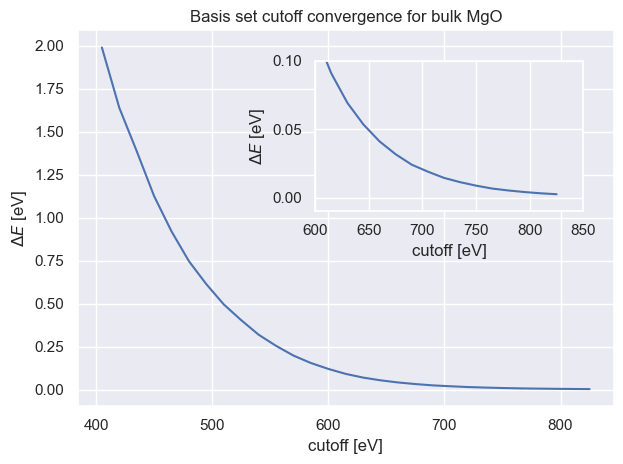

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
path = './structures/MgO_bulk_eos/cutoff_conv_castep_files'
data = []
listOfFiles = os.listdir(path)
for file in listOfFiles:
    if '.castep' in file:
        temp_output = CastepOutput(path = path+'/'+file)
        data.append([temp_output.ks_total_energy,temp_output.basis_set_cutoff])
df_data = pd.DataFrame(data,columns=['Total_Energy','Cutoff'])
df_data['dE'] = abs(df_data['Total_Energy'] - df_data['Total_Energy'].shift(1))
sns.set_theme()
ax = sns.lineplot(df_data,x='Cutoff',y='dE')
ax.set(xlabel='cutoff [eV]',ylabel=r'$\Delta E$ [eV]')
axins = inset_axes(ax,  "50%", "40%" ,loc="upper right",borderpad=2)
axins.set(ylim=(-0.01,0.1),xlim=(600,850),xlabel='cutoff [eV]',ylabel=r'$\Delta E$ [eV]')
sns.lineplot(df_data,x='Cutoff',y='dE')
ax.set_title('Basis set cutoff convergence for bulk MgO')
plt.tight_layout()
plt.savefig('./structures/MgO_bulk_eos/Convergence_MgO_bulk.png',dpi=200)

### Cutoff Convergence for Ag100 with different USPPs

In [ ]:
paths = {
    'std_new' : './structures/Ag100_pseudo/Ag100_new19_cut_6-8h',
    'fine_new' : './structures/Ag100_pseudo/Ag100_new19_cut_6-8h_fine',
    'precise_new' :  './structures/Ag100_pseudo/Ag100_new19_cut_6-8h_precise',
    'ultra_new' : './structures/Ag100_pseudo/Ag100_new19_cut_6-8h_ultra',
    'std_old' : './structures/Ag100_pseudo/Ag100_old19_cut_6-8h',
    'fine_old' : './structures/Ag100_pseudo/Ag100_old19_cut_6-8h_fine',
    'precise_old' :  './structures/Ag100_pseudo/Ag100_old19_cut_6-8h_precise',
}
cutoff_energies = range(600,855,5)
energies = {'std_old':[],'fine_old':[],'precise_old':[],'std_new':[],'fine_new':[],'precise_new':[],'ultra_new':[]}
cutoffs = {'std_old':[],'fine_old':[],'precise_old':[],'std_new':[],'fine_new':[],'precise_new':[],'ultra_new':[]}
for key in paths.keys():
    listOfFiles = os.listdir(paths[key])
    for file in listOfFiles:
        if '.castep' in file:
            temp_output = CastepOutput(path = paths[key]+'/'+file)
            energies[key].append(temp_output.ks_total_energy)
            cutoffs[key].append(temp_output.basis_set_cutoff)
sns.set_theme(style="darkgrid", font_scale=1.7)
fig, axes = plt.subplots(1, 1, figsize=(15, 10),dpi=200)
#axes[0].set(title='Old 19e PseudoPotential\nAg 3|1.6|14|16|18|40U:50:41:42(qc=7)\n(CASTEP 16.1 OTFG)',xlabel='Cutoff Energy [eV]',ylabel='Total Energy [eV]')
axes.set(title='New 19e PseudoPotential\nAg 3|1.5|1.5|0.8|15|17|19|40U:50:41:42(qc=7)\n(CASTEP 18.1 OTFG)',xlabel='Cutoff Energy [eV]',ylabel='Total Energy [eV]')
# Plot the responses for different events and regions
#graph = sns.lineplot(x=cutoff_energies, y=energies['std_old'],label='Old Pot. - std grid')
# graph = sns.lineplot(ax=axes[0],x=cutoffs['std_old'], y=energies['std_old'],label='standard grid (f=1.75)')
# graph = sns.lineplot(ax=axes[0],x=cutoffs['fine_old'], y=energies['fine_old'],label='fine grid (f=2.0)')
# graph = sns.lineplot(ax=axes[0],x=cutoffs['precise_old'], y=energies['precise_old'],label='precise grid (f=2.3)')
#graph = sns.lineplot(ax=axes[1],x=cutoffs['std_new'], y=energies['std_new'],label='standard grid (f=1.75)')
#graph = sns.lineplot(ax=axes[1],x=cutoffs['fine_new'], y=energies['fine_new'],label='fine grid (f=2.0)')
graph = sns.lineplot(x=cutoffs['precise_new'], y=energies['precise_new'],label='precise grid (f=2.3)')
graph = sns.lineplot(x=cutoffs['ultra_new'], y=energies['ultra_new'],label='more precise grid (f=2.6)')
#axes[0].axvline(x=784,label='PP cutoff extreme',ls='--',c = 'r')
axes.axvline(x=827,label='PP cutoff extreme',ls='--',c = 'r')
axes.legend()
#axes[1].legend()
plt.tight_layout()
plt.savefig('./structures/plots/Ag100_cutoff_comp_precise.png',dpi =200)
#print(energies)

### Castep 18.1 OTFG PP Cutoff Convergence for Ag100

In [ ]:
sns.set_theme(style="darkgrid", font_scale=1.2)
energies,cutoffs = [],[]
path = './structures/Ag_convergence/'
listOfFiles = os.listdir(path)
for file in listOfFiles:
    if '.castep' in file:
        temp_output = CastepOutput(path = path+file)
        energies.append(temp_output.ks_total_energy)
        cutoffs.append(temp_output.basis_set_cutoff)
fig, axes = plt.subplots(1, 1, figsize=(10, 5),dpi =200)
graph = sns.scatterplot(x=cutoffs, y=energies,label='standard grid (f=1.75)')
graph.set(title='New 19e PseudoPotential\n3|1.5|1.5|0.8|15|17|19|40U:50:41:42(qc=7)\n(CASTEP 18.1 OTFG)',xlabel='Cutoff Energy [eV]')#,xlim = [500,850])
axes.axvline(x=827,label='cutoff extreme',ls='--',c = 'r')
axes.legend()


    5.414020    0.000000    0.000000

    0.000000    5.414020    0.000000

    0.000000    0.000000   76.565799

[[5.41402, 0.0, 0.0], [0.0, 5.41402, 0.0], [0.0, 0.0, 76.565799]]
{'\\Gamma': array([0., 0., 0.]), 'A': array([0.5, 0.5, 0.5]), 'M': array([0.5, 0.5, 0. ]), 'R': array([0. , 0.5, 0.5]), 'X': array([0. , 0.5, 0. ]), 'Z': array([0. , 0. , 0.5])} [0, 11, 27, 38]
39
True


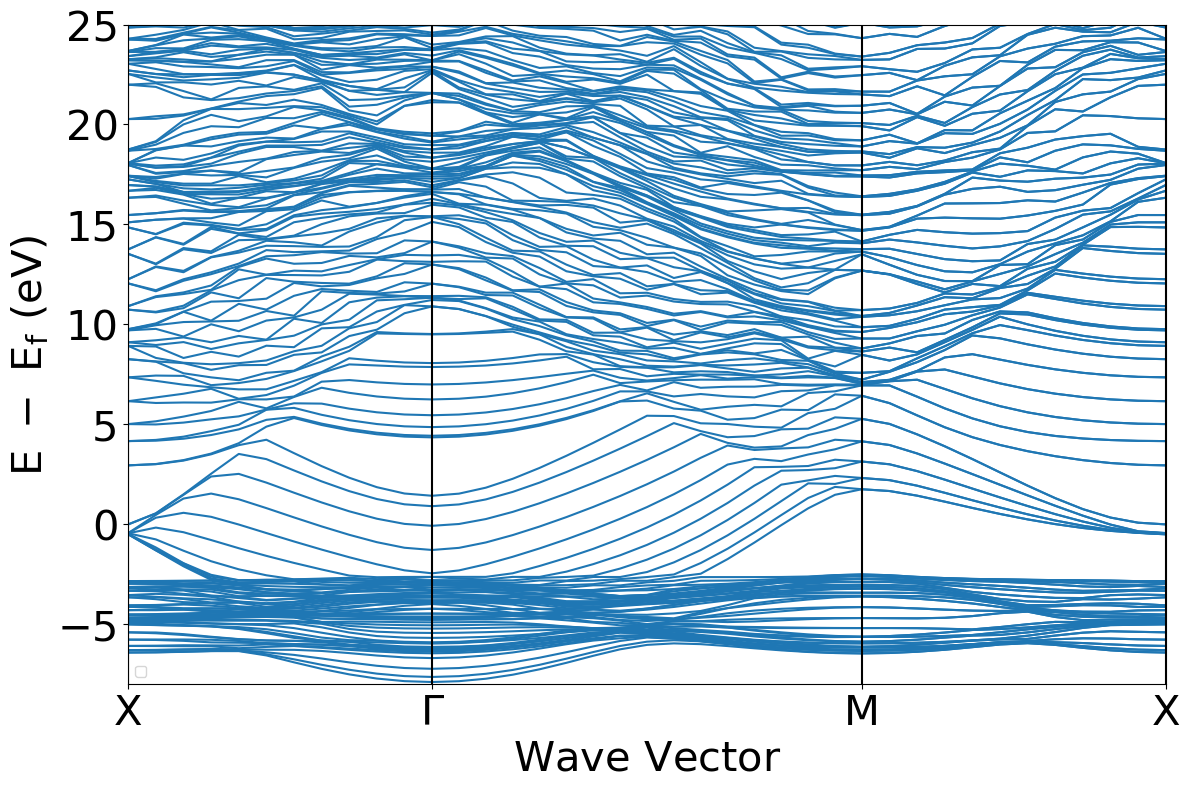

In [22]:
bands_ag100 = read_bands2pmg(path='./OD_debug_files/OD_visualisation_tests/', suffix='.bands',cell_file = './OD_debug_files/OD_visualisation_tests/'+'/Ag100_fine_grid_spectral.cell')
print(bands_ag100.is_metal())
ylim=[-8,25]
bs_plot = BSPlotter(bands_ag100)
bs_plot.get_plot(ylim=ylim)
plt.legend([])
plt.savefig('./Ag100_bs_xgmx_trans.png',dpi=400,transparent=True)

# Cu100 Plotting

## Cu100 BS

In [3]:
path_z1 = './OD_debug_files/Cu100_pos_and_vol/middle/'
suffix = 'bands'
bands_z1 = read_bands2pmg(path=path_z1+'z1/', suffix=suffix, cell_file=path_z1+'z1/Cu100_od_rerun_spectral.cell')
# bands_v10 = read_bands2pmg(path=path_z1+'v10/', suffix=suffix, cell_file=path_z1+'v10/Cu100_v10.cell')
# bands_z3 = read_bands2pmg(path=path_z1+'z3/', suffix=suffix, cell_file=path_z1+'z3/Cu100_od_rerun_spectral.cell')
# bands_z5 = read_bands2pmg(path=path_z1+'z5/', suffix=suffix, cell_file=path_z1+'z5/Cu100_od_rerun_spectral.cell')
# plotter =  BSPlotter(bands_z1)
# plotter.add_bs(bands_z3)
# plotter.add_bs(bands_z5)
# plotter.get_plot(ylim=[4,15],bs_labels=['z1','z3','z5'])
# plt.savefig('./OD_debug_files/Cu100_pos_and_vol/middle/Comp_4_15_bs_z1-5.png',dpi=250)

bands
o2b
orig
casino
out
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
odo
cell
od_fermi
od_photo_files
plots
    4.718160    0.000000    0.000000

    0.000000    4.718160    0.000000

    0.000000    0.000000   94.486306

[[4.71816, 0.0, 0.0], [0.0, 4.71816, 0.0], [0.0, 0.0, 94.486306]]
{'\\Gamma': array([0., 0., 0.]), 'A': array([0.5, 0.5, 0.5]), 'M': array([0.5, 0.5, 0. ]), 'R': array([0. , 0.5, 0.5]), 'X': array([0. , 0.5, 0. ]), 'Z': array([0. , 0. , 0.5])} [0, 252, 608, 860]
861


In [3]:
pdos_1,pmg_z1 = read_proj_dos_optados('./OD_debug_files/Cu100_pos_and_vol/middle/z1/od_fermi/')
pdos_3,pmg_z3 = read_proj_dos_optados('./OD_debug_files/Cu100_pos_and_vol/middle/z3/od_fermi/')
pdos_5,pmg_z5 = read_proj_dos_optados('./OD_debug_files/Cu100_pos_and_vol/middle/z5/od_fermi/')
pdos_10,pmg_v10 = read_proj_dos_optados('./OD_debug_files/Cu100_pos_and_vol/middle/v10/od_fermi/')
# print(pmg_z1)
# pmg_z1 = Dos(efermi=0,energies=pdos_1['energies'],densities=pdos_1['totals'])
# print(pdos_1['totals'])
print(pmg_z1.energies)
print(pmg_z1.densities[Spin.up].shape)
# fig,ax = plot_proj_dos_optados(pdos_1)

[-8.9396227 -8.9386227 -8.9376226 ... 35.203236  35.204236  35.205236 ]
(44145,)


In [ ]:
list(zip(pdos_10['energies'],pdos_10['totals'][Spin.up]))

In [15]:
np.savetxt('./OD_debug_files/Cu100_pos_and_vol/middle/v10/od_fermi/PDOS_total.csv',list(zip(pdos_10['energies'],pdos_10['totals'][Spin.up])),delimiter=';')

<Figure size 1000x1000 with 0 Axes>

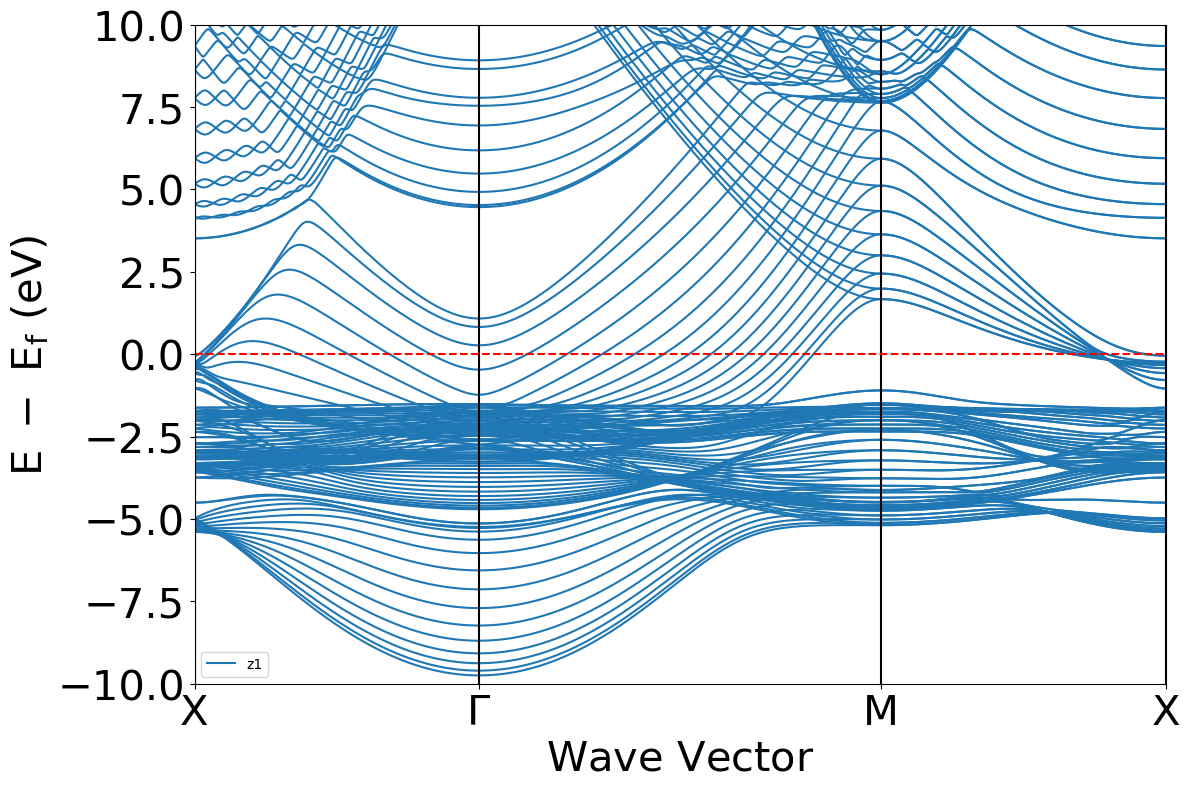

In [4]:
ylim=[4.3,6.0]
bs_plot = BSPlotter(bands_z1)
# bs_plot.add_bs(bands_v10)
# bs_plot.add_bs(bands_z3)
# bs_plot.add_bs(bands_z5)
# dos_plot = DosPlotter()
# dos_plot.add_dos('z1',dos=pmg_z1)
# dos_plot.add_dos('z3',dos=pmg_z3)
# dos_plot.add_dos('z5',dos=pmg_z5)
fig = plt.figure(figsize=(10, 10))
subfigs = fig.subfigures(1, 2,width_ratios=(3,1))
subfigs[0] = bs_plot.get_plot()
subfigs[0].legend(labels=['z1'])
subfigs[0].hlines(y=0,xmin=0,xmax=2.3,color='r',linestyle='--')
# subfigs[1] = dos_plot.get_plot(xlim=ylim)#,ylim=[0,10])
# plt.savefig('./OD_debug_files/Cu100_pos_and_vol/middle/BS_v10_v23_zoomed3.png',dpi=250)

AttributeError: 'function' object has no attribute 'ylim'

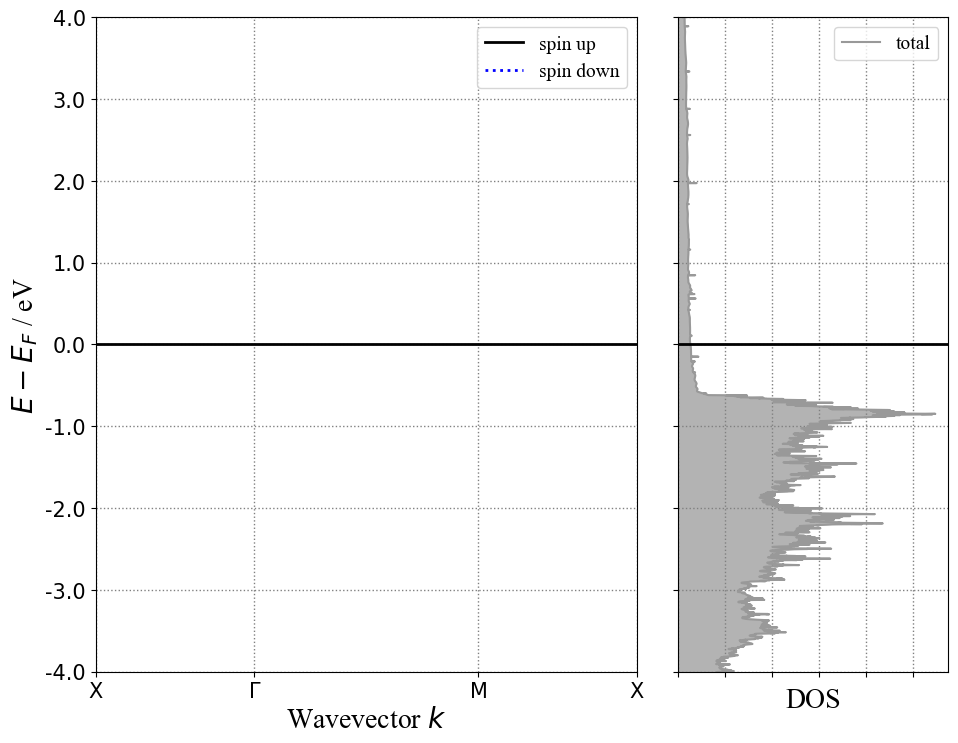

In [11]:
plotter_bsdos = BSDOSPlotter()
fig = plotter_bsdos.get_plot(bs=bands_z1, dos=pmg_z1)
fig.axes.ylim([-10,10])
fig.axes[1].ylim([-10,10])

None


<module 'matplotlib.pyplot' from 'c:\\Users\\fcm19\\Miniconda3\\envs\\matchem\\lib\\site-packages\\matplotlib\\pyplot.py'>

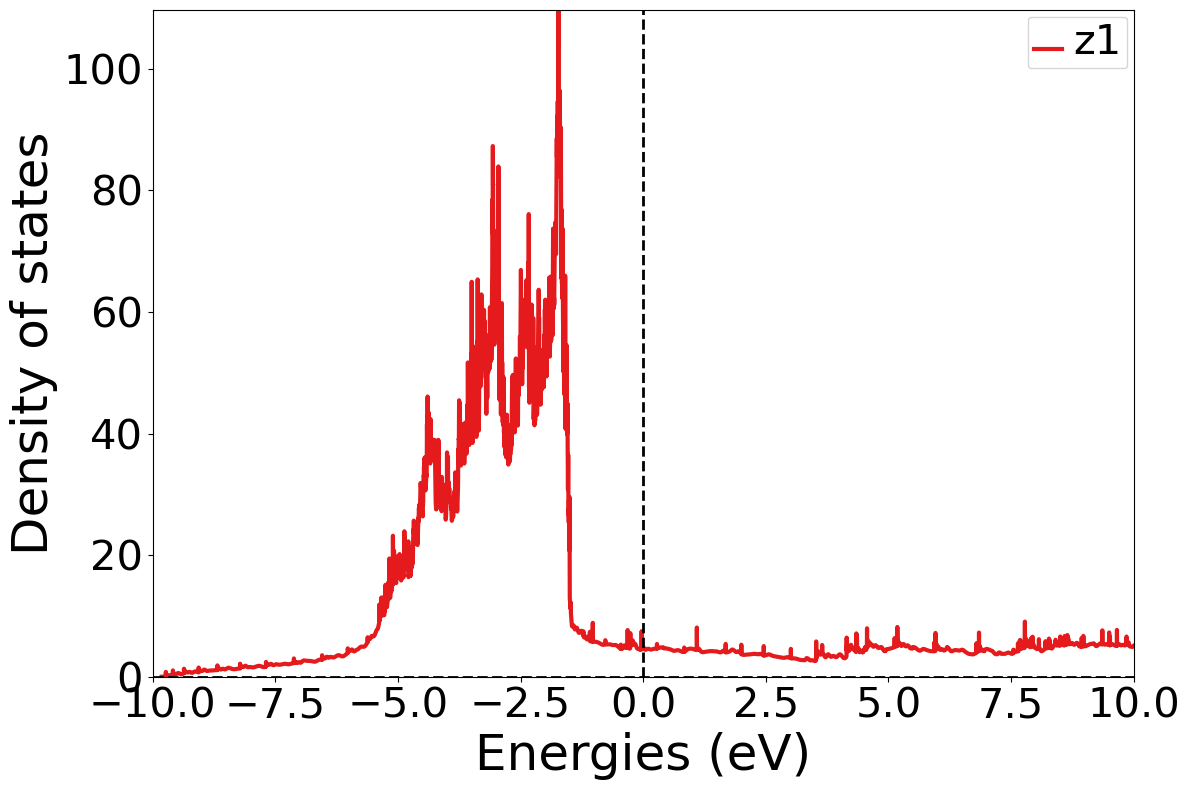

In [4]:
plotter = DosPlotter()
print(plotter.sigma)
plotter.add_dos('z1',pmg_z1)
# print(pmg_z1.as_dict())
# print(plotter._doses)
plotter.get_plot(xlim=[-10,10])

# Bulk Cu

## Cutoff Convergence for bulk Cu

In [ ]:
seed = 'Cu_bulk_'
path_pbe = './structures/Cu_bulk_convergence/k_points/'
path_sol = './structures/Cu_bulk_convergence/k_points/PBEsol/'
cutoffs = [2,4,6,8,9,10,12,14,16,18]
tot_energies, differences = {'pbe' : [],'pbesol' : []},{'pbe' : [],'pbesol' : []}
for cut in cutoffs:
    temp_pbe = CastepOutput(path = f'{path_pbe}{seed}{cut}/{seed}{cut}.castep')
    temp_sol = CastepOutput(path= f'{path_sol}{seed}{cut}/{seed}{cut}.castep')
    tot_energies['pbe'].append(temp_pbe.ks_total_energy)
    tot_energies['pbesol'].append(temp_sol.ks_total_energy)

for i in range(1,len(cutoffs)):
    differences['pbe'].append(abs(tot_energies['pbe'][i]-tot_energies['pbe'][i-1]))
    differences['pbesol'].append(abs(tot_energies['pbesol'][i]-tot_energies['pbesol'][i-1]))

#print('Differences:', differences)
#print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
print(differences)
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbe'])
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbesol'],alpha = 0.5)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'k-point grid #x#x#', ylabel = r'$\Delta E_{tot}$', title = 'K-Point Grid Convergence')
graph.set(xlim = (5.9,18), ylim =  (-0.01,0.1))
plt.legend(labels=[r'PBE','PBEsol',r'$\frac{1}{2}kT$'])
plt.savefig('./structures/plots/comparison_kpoints_zoom.png',dpi = 250)

### Cu100 prim vs 2x2 supercell bandstruct

In [ ]:
def read_bands2pmg(path:str=None, export = False):
    num_kpoints, num_spin_comps, num_electrons_up, num_electrons_down, num_bands, fermi_energy = 0,0,0,0,0,0
    kpts_coordinates = []
    eigenvalues = {}
    cell = []
    if path == None:
        path = f'./structures/'
    if path[-1] != '/': path += '/'
    listOfFiles = os.listdir(path)
     # create output classes for each of the output files
    for item in listOfFiles:
        if '.bands' in item[-6:] and '.orig' not in item and '.o2b' not in item:
            seed = item.replace('.bands','')
            with open(f'{path}{item}','r') as f:
                for line in f:
                    line = line.strip()
                    if 'Number of k-points' in line:
                        num_kpoints = int(line.split()[3])
                        num_spin_comps = int(next(f).split()[4])
                        num_electrons = next(f).split()
                        num_electrons_up = float(num_electrons[3])
                        num_bands = int(next(f).split()[3])
                        fermi_energy = float(next(f).split()[5])*27.2113966
                        #print(fermi_energy)

                        kpts_coordinates = np.zeros((num_kpoints,3))
                        eigenvalues[Spin.up] = np.zeros([num_bands, num_kpoints])
                        if num_spin_comps > 1:
                            num_electrons_down = float(num_electrons[4])
                            eigenvalues[Spin.down] = np.zeros([num_bands, num_kpoints])

                        next(f)
                        for i in range(3):
                            line = next(f)
                            print(line)
                            cell.append([float(x) for x in line.split()])
                        print(cell)
                        lattice_obj = Lattice(cell)

                    if line.split()[0] == 'K-point':
                        temp = line.split()
                        index = int(temp[1])-1
                        kpts_coordinates[index] = [float(temp[2]),float(temp[3]),float(temp[4])]
                        next(f)
                        for i in range(num_bands):
                            eigenvalues[Spin.up][i][index] = float(next(f).strip())*27.2113966
                        if num_spin_comps > 1:
                            next(f)
                            for i in range(num_bands):
                                eigenvalues[Spin.down][i][index] = float(next(f).strip())*27.2113966
    for item in listOfFiles: 
        if '_geometry.cell' in item: 
            cell_item=item
    kpt_path = KPathSetyawanCurtarolo(SpacegroupAnalyzer(read_cell2pmg(f'{path}{cell_item}')).get_primitive_standard_structure()) #Should use the Setyawan-Curtarolo Convention
    high_symm_dict, high_symm_indices = create_label_dict(kpt_path, kpts_coordinates)
    final_kpt_coordinates = np.zeros((num_kpoints+len(high_symm_indices)-2,3))
    final_eigenvalues = {Spin.up : np.zeros([num_bands, num_kpoints+len(high_symm_indices)-2])}
    if num_spin_comps > 1:
        final_eigenvalues = {Spin.down : np.zeros([num_bands, num_kpoints+len(high_symm_indices)-2])}
    
    for i in range(len(high_symm_indices)-1):
        final_kpt_coordinates[high_symm_indices[i]+i:high_symm_indices[i+1]+1+i] = kpts_coordinates[high_symm_indices[i]:high_symm_indices[i+1]+1]
        final_eigenvalues[Spin.up][:,high_symm_indices[i]+i:high_symm_indices[i+1]+1+i] = eigenvalues[Spin.up][:,high_symm_indices[i]:high_symm_indices[i+1]+1]
        if num_spin_comps > 1:
           final_eigenvalues[Spin.down][:,high_symm_indices[i]+i:high_symm_indices[i+1]+1+i] = eigenvalues[Spin.down][:,high_symm_indices[i]:high_symm_indices[i+1]+1]
    new_bandstruct = BandStructureSymmLine(final_kpt_coordinates, final_eigenvalues,lattice_obj.reciprocal_lattice, fermi_energy,high_symm_dict,coords_are_cartesian=False);
    if export:
        with open(f'./structures/band_jsons/{seed}.json', 'w') as f:
            json.dump(new_bandstruct.as_dict(), f)
    return new_bandstruct;

In [39]:
kpt =  KPathSetyawanCurtarolo(SpacegroupAnalyzer(read_cell2pmg('./structures/Cu100_1x1/Cu100_1x1_geometry.cell')).get_primitive_standard_structure())
print(kpt.kpath)

{'kpoints': {'\\Gamma': array([0., 0., 0.]), 'A': array([0.5, 0.5, 0.5]), 'M': array([0.5, 0.5, 0. ]), 'R': array([0. , 0.5, 0.5]), 'X': array([0. , 0.5, 0. ]), 'Z': array([0. , 0. , 0.5])}, 'path': [['\\Gamma', 'X', 'M', '\\Gamma', 'Z', 'R', 'A', 'Z'], ['X', 'R'], ['M', 'A']]}


    4.718160    0.000000    0.000000

    0.000000    4.718160    0.000000

    0.000000    0.000000   94.486306

[[4.71816, 0.0, 0.0], [0.0, 4.71816, 0.0], [0.0, 0.0, 94.486306]]
[{'name': '\\Gamma-\\Gamma', 'start_index': 0, 'end_index': 0, 'index': 0}, {'name': '\\Gamma-\\Gamma', 'start_index': 1, 'end_index': 1, 'index': 1}, {'name': '\\Gamma-\\Gamma', 'start_index': 2, 'end_index': 2, 'index': 2}, {'name': '\\Gamma-\\Gamma', 'start_index': 3, 'end_index': 3, 'index': 3}, {'name': '\\Gamma-\\Gamma', 'start_index': 4, 'end_index': 4, 'index': 4}, {'name': '\\Gamma-\\Gamma', 'start_index': 5, 'end_index': 5, 'index': 5}, {'name': '\\Gamma-\\Gamma', 'start_index': 6, 'end_index': 6, 'index': 6}, {'name': '\\Gamma-\\Gamma', 'start_index': 7, 'end_index': 7, 'index': 7}, {'name': '\\Gamma-\\Gamma', 'start_index': 8, 'end_index': 8, 'index': 8}, {'name': '\\Gamma-\\Gamma', 'start_index': 9, 'end_index': 9, 'index': 9}, {'name': '\\Gamma-\\Gamma', 'start_index': 10, 'end_index': 10, 'inde

AttributeError: 'NoneType' object has no attribute 'label'

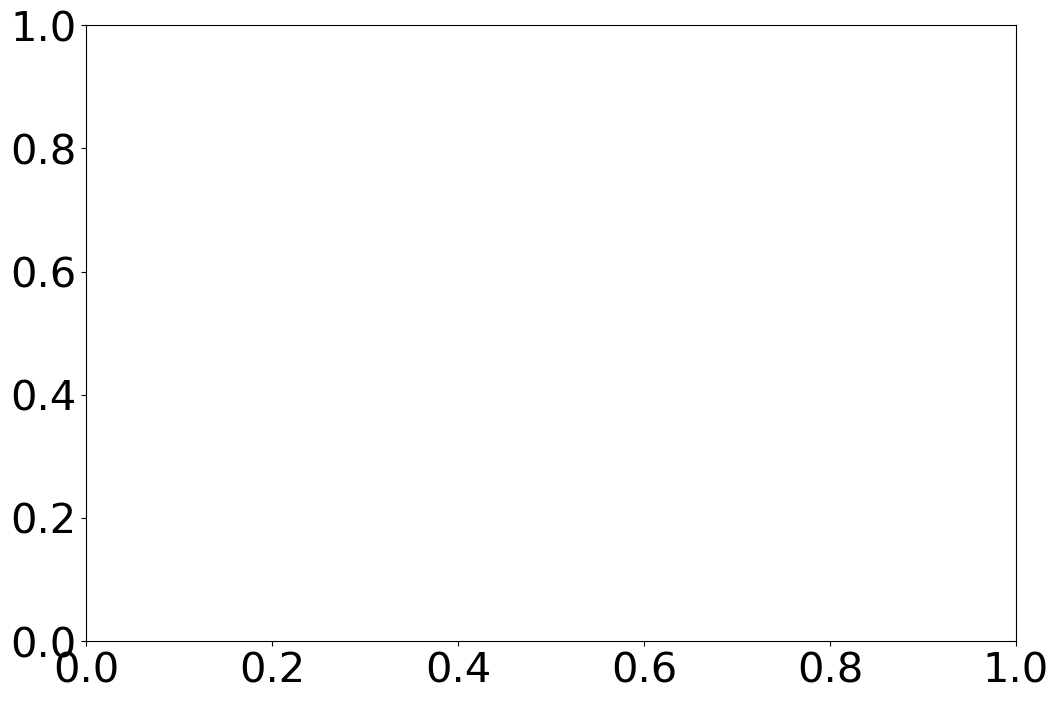

In [7]:
prim_bands = read_bands2pmg('./structures/Cu100_1x1/')
print(prim_bands.get_branch(0))
plotter =  BSPlotter(prim_bands)
plotter.get_plot(ylim=[-7,12])

## Create scaled volume inputs, read the output files and create murnaghan plot

In [ ]:
bulk = Structure.from_file(filename="./structures/data_files/materials/Ag_primitive.cif")
create_murnaghan_inputs(seed = 'Ag_bulk_eos', structure=bulk, cutoff = 750, kpoints=[16,16,16], min_max=(0.9,1.1,10))

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')
plt.savefig(f'./structures/plots/{seed}_pbesol.png',dpi = 300)

In [ ]:
from pymatgen.analysis.eos import EOS
volumes = [4.0217**3,4.0323**3,4.04291**3,4.0535**3,4.0641**3,4.0747**3,4.0852**3,4.0958**3,4.1064**3,4.1170**3,4.1276**3,4.1382**3,4.1487**3,4.1593**3,4.1699**3,4.1805**3,4.1911**3,4.2017**3,4.2123**3,4.2228**3,4.2334**3]
energies = [-5166.735408,-5166.771831,-5166.804691,-5166.833949,-5166.859863,-5166.88241,-5166.901863,-5166.918194,-5166.931514,-5166.942021,-5166.949902,-5166.95521,-5166.958079,-5166.958385,-5166.956323,-5166.952268,-5166.94582,-5166.93757,-5166.927327,-5166.915218,-5166.901135]
eos = EOS(eos_name='murnaghan')
fit = eos.fit(volumes, energies)
fit.plot()

In [ ]:
print(fit.results['v0'])

In [ ]:
ag_bulk = AseAtomsAdaptor.get_structure(read('./structures/input.txt',format='espresso-in'))
ag_bulk.scale_lattice(fit.results['v0'])
print(ag_bulk)

## Read the Results for Kpoint grid convergence and plot as graph

ToDo: Modify the Kpoint convergence generation function to make a single input and then vary the values within the PBS script

In [ ]:
seeds = ['Cu_bulk_2','Cu_bulk_4','Cu_bulk_6','Cu_bulk_8','Cu_bulk_9','Cu_bulk_10','Cu_bulk_12','Cu_bulk_14','Cu_bulk_16','Cu_bulk_18']
tot_energies = []
differences = []
kpoints = [4,6,8,9,10,12,14,16,18]
kpoints2 = kpoints[1:]
for seed in seeds:
    temp_out = CastepOutput(path = f'./structures/kpt_convergence/{seed}.castep')
    tot_energies.append(temp_out.ks_total_energy)
for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences.append(abs(tot_energies[i+1]-tot_energies[i]))
sns.set_theme(style="darkgrid")
differences_2 = differences[1:]
#print(differences_2)
# Plot the responses for different events and regions
graph = sns.lineplot(x=kpoints2, y=differences_2)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'MP k-point grid size (x,x,x)', ylabel = r'$\Delta E_{tot}$ [eV]', title = 'K-point Grid Convergence')
plt.legend(labels=[r'$\Delta$ E',r'$\frac{1}{2}kT$'])
#plt.savefig('./structures/plots/k_point_convergence_zoom.png',dpi = 300)

In [ ]:
atoms = [8,10,12,14,15,16]

bulk_energy = -1676.5954
cell_100 = read_cell2pmg('./structures/layer_convergence/100/Cu100_geom.cell')
cell_110 = read_cell2pmg('./structures/layer_convergence/110/Cu110_geom.cell')
cell_111 = read_cell2pmg('./structures/layer_convergence/111/Cu111_geom.cell')

total_energies_100 = [-13411.42595553,-16764.64359063,-20117.86115268,-23471.07926522,-25147.68758931,-26824.29928175]
total_energies_110 = [-13410.69670576,-16763.92313970,-20117.14478342,-23470.36493049,-25146.96980282,-26823.58389667]
total_energies_111 = [-13411.73832259,-16764.95286620,-20118.17369990,-23471.39220467,-25147.99980183,-26824.61125253]

data = {
    100: [total_energies_100[i]/atoms[i] for i in range(len(atoms))],
    110: [total_energies_110[i]/atoms[i] for i in range(len(atoms))],
    111: [total_energies_111[i]/atoms[i] for i in range(len(atoms))]
}
diff = {
    100:[data[100][i-1]-data[100][i] for i in range(1,len(atoms))],
    110:[data[110][i-1]-data[110][i] for i in range(1,len(atoms))],
    111:[data[111][i-1]-data[111][i] for i in range(1,len(atoms))],
}

surf_energies = {
    100: [calc_surface_energy(bulk_energy, total_energies_100[i],atoms[i], cell_100.lattice.volume/cell_100.lattice.c) for i in range(len(atoms))],
    110: [calc_surface_energy(bulk_energy, total_energies_110[i],atoms[i], cell_110.lattice.volume/cell_110.lattice.c) for i in range(len(atoms))],
    111: [calc_surface_energy(bulk_energy, total_energies_111[i],atoms[i], cell_111.lattice.volume/cell_111.lattice.c) for i in range(len(atoms))],
}

diff_surf = {
    100:[surf_energies[100][i]-surf_energies[100][i-1] for i in range(1,len(atoms))],
    110:[surf_energies[110][i]-surf_energies[110][i-1] for i in range(1,len(atoms))],
    111:[surf_energies[111][i]-surf_energies[111][i-1] for i in range(1,len(atoms))],
}
surface = 111

print([surf_energies[surface][i]*16.02176565 for i in range(len(atoms))])

fig,ax = plt.subplots(1,1)
ax.plot(atoms[1:], diff[surface])
ax.set(xlabel='# of slab layers', ylabel = r'$\Delta$ total energy per atom [eV]', title = f'Convergence test for Cu({surface}) surface')
#ax.plot(atoms, data[surface])
#ax.set(xlabel='# of slab layers', ylabel = 'total energy per atom [eV]', title = f'Convergence test for Cu({surface})')
#ax.plot(atoms,surf_energies[surface])
#ax.set(xlabel='# of slab layers', ylabel = 'surface energy [eV]', title = f'Convergence test for Cu({surface})')
#ax.plot(atoms[1:],diff_surf[surface])
#ax.set(xlabel='# of slab layers', ylabel = r'$\Delta$ surface energy [eV]', title = f'Convergence test for Cu({surface})')
plt.tight_layout()
#plt.savefig()

In [ ]:
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(1,2, figsize = [12,5])
ax[0].set(xlabel='# of slab layers', ylabel = 'Total Energy [eV]')
ax[1].set(xlabel='# of slab layers', ylabel = r'$\Delta$ total energy per atom [eV]')
for item in diff:
    ax[0].plot(atoms, data[item], label = f'Cu({item})')
    ax[1].plot(atoms[1:], diff[item], label = f'Cu({item})')
ax[1].plot(atoms[1:], [0.01 for x in range(len(atoms)-1)], ls = '--', lw = 1)
plt.suptitle('Convergence test for Cu surfaces')
ax[1].legend()
ax[0].legend()
plt.tight_layout()
plt.savefig('./structures/plots/Cu_surfaces_layer_convergence_comp.png',dpi = 500)

## Read in the geometry optimisation trajectory file

In [ ]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

data = read_geometry_traj_file(path = './structures/')

In [ ]:
data = []
directories = {
    'Ag':'./structures/AgMgO_interface/victor_qe/Ag100/od_out/',
    'AgMgO1':'./structures/AgMgO_interface/victor_qe/AgMgO/1/od_out/',
    'AgMgO2':'./structures/AgMgO_interface/victor_qe/AgMgO/2/od_out/',
    'AgMgO3':'./structures/AgMgO_interface/victor_qe/AgMgO/3/od_out/',
    'AgMgO5':'./structures/AgMgO_interface/victor_qe/AgMgO/5/od_out/',
    'AgMgO6':'./structures/AgMgO_interface/victor_qe/AgMgO/6/od_out/',
    'AgMgO7':'./structures/AgMgO_interface/victor_qe/AgMgO/7/od_out/',
    'AgMgO8':'./structures/AgMgO_interface/victor_qe/AgMgO/8/od_out/',
    }
# directories = {
#     'fem':'./OD_debug_files/Graphene/fem/',
#     'ome_new':'./OD_debug_files/Graphene/ome_new/',
#     }

for key in directories.keys():
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            temp_object = OptaDOSOutput(directories[key]+item)
            data.append([key,temp_object.photo_model,temp_object.photo_photon_energy,'QE',temp_object.qe,temp_object.photo_work_function,temp_object.photo_photon_energy - temp_object.photo_work_function])
            data.append([key,temp_object.photo_model,temp_object.photo_photon_energy,'MTE',temp_object.mte*1000,temp_object.photo_work_function,temp_object.photo_photon_energy - temp_object.photo_work_function])
data = pd.DataFrame(data, columns=['System', 'Photo Model','Photon Energy [eV]','Value Type','Value','Work Function [eV]', 'Excess Energy [eV]'])
data

In [ ]:
data[data['Photon Energy [eV]'] == 4.7]

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(data, col='Value Type', hue = "System",sharey=False,height=6,aspect= 8/8)
grid.map(sns.lineplot,'Excess Energy [eV]','Value')
grid.fig.get_axes()[0].set(yscale = 'log')
grid.fig.get_axes()[0].set_ylim([1E-7,1E-1])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
#plt.savefig('./OD_debug_files/Graphene/Comparison_overall.png',dpi=200)

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(data, col='Value Type', hue = "System",sharey=False,height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','Value')
grid.fig.get_axes()[0].set(yscale = 'log')
grid.fig.get_axes()[0].set_ylim([1E-8,1E-1])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
#plt.savefig('./OD_debug_files/Graphene/Comparison_overall.png',dpi=200)

### Plot the electronic densities and potential

In [ ]:
fig,ax = create_density_plot(directory = './structures/Ag100_victor/', centered = False)
plt.tight_layout()
#plt.savefig('./structures/plots/Cu110_victor_60A_density_plot.png')

In [ ]:
fig,ax = create_potential_plot(directory='./structures/Ag100_victor/', centered = False)
plt.tight_layout()
#plt.savefig(f'./structures/plots/Cu110_pbesol_14L_50A_potential_plot.png')

In [ ]:
fig,ax = create_potential_plot(directory='./structures/Ag100_felix_nc/', centered = False,bounds=[5,12])
plt.tight_layout()

## Create Plot with modified pymatgen functions to create more colourful bandstructure plot

In [ ]:
%matplotlib inline
bandstructure_cu = read_bands2pmg(path='./structures/GaAs_bulk/GaAs_bulk_pbesol/', export=False)
#print(bandstructure_cu.distance)
output = []
for kpt in bandstructure_cu.kpoints:
    output.append((kpt.label,kpt.cart_coords))
plot = get_bs_plot(bandstructure_cu,ylim = (-5,5),size=[10,10])
#print(bandstructure_cu.as_dict()[''])
#plt.savefig('./structures/plots/Cu100_60_rerun_bandstruct_-3_1.png',dpi=200)

## Plot reference Cu Bandstructure from Materials Project 

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_new = BandStructureSymmLine.from_dict(d)

plotter = BSPlotter(bandstruct_new)
#print(bandstruct_new.as_dict()['branches'])
#print(bandstruct_new.get_branch(320))
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_PBEsol.json', 'r') as f:
    d = json.load(f)
    full = BandStructureSymmLine.from_dict(d)
full.efermi = 5.2
plotter = BSPlotter(full)
plotter.add_bs(bandstruct_new)
plotter.get_plot(ylim=[-11,25], bs_labels = ['PBEsol claculated', 'Materials Project reference'])
plt.savefig('./structures/plots/Cu_bulk_pbesol_bandstruct_comp_mp_ref.png', dpi = 300)


In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_all_points.json', 'r') as f:
    d = json.load(f)
    full_pbe = BandStructureSymmLine.from_dict(d)
full_pbe.efermi = 5.0
plotter = BSPlotter(full_pbe)
plotter.add_bs(bandstruct_new)
plotter.get_plot(ylim=[-11,25], bs_labels = ['PBE claculated', 'Materials Project reference'])
plt.savefig('./structures/plots/Cu_bulk_pbe_bandstruct_comp_mp_ref.png', dpi = 300)

In [ ]:
bandstructure_ag = read_bands2pmg(path='./structures/Ag100_fine_grid', export=False)
bandstructure_ag_relax = read_bands2pmg(path='./structures/Ag100_fine_grid_relax', export=False)
plotter = BSPlotter(bandstructure_ag)
plotter.add_bs(bandstructure_ag_relax)
plotter.get_plot(ylim=[-8,10],bs_labels = ['unrelaxed', 'relaxed'])
plt.savefig('./structures/plots/Ag100_fine_bandstruct.png',dpi=200)

In [ ]:
bs_cu100 = read_bands2pmg(path='./structures/Cu100_60_rerun', export=False)
plotter = BSPlotter(bs_cu100)
plotter.get_plot(ylim=[-10,10],bs_labels = ['unrelaxed', 'relaxed'])
plt.savefig('./structures/plots/Cu100_rerun_bandstruct.png',dpi=200)

## Plot bandstructure from castep .bands file using ASE functions

In [ ]:
#bandfile = create_bands_file(calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Fe_metal_bcc.cif")),seed = 'Fe')
seed = 'Ag100_felix'
#calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Cu_metal_fcc.cif"))
calc_struct = AseAtomsAdaptor().get_atoms(read_cell2pmg(f'./structures/{seed}/{seed}_geometry.cell'))
calc = ase.calculators.castep.Castep(check_castep_version = False,keyword_tolerance=3)
calc_struct.calc = calc
bandstructure = calc_struct.calc.band_structure(bandfile=f'./structures/{seed}/{seed}.bands').subtract_reference()
#print(bandstructure.get_labels())
plt.style.use('seaborn')
#ax.ylimit(-12,35)
bandstructure.plot(emin=-10, emax=10)

## Read in the photon energy sweep output files

In [ ]:
surfaces = [100,110,111]
Cu_surf_data = {}
surface_exp = {111 : np.array([[3.96,23.0],[4.09,35.5],[4.23,77.70],[4.38,57.80],[4.54,105.00],[4.71,156.50],[4.90,266.60],[5.14,336.00],[5.39,520.80]]),
100 : np.array([[4.26,30.6],[4.34,35.1],[4.41,42],[4.49,62.8],[4.58,88.5],[4.66,124.3],[4.71,140.1],[4.81,153.1],[4.9,194.5],[5,257.6],[5.1,262.1],[5.25,312.7],[5.49,386.1]]),
110 : np.array([[4.12,12.9],[4.15,17.7],[4.19,17.2],[4.26,31.9],[4.34,60.8],[4.41,92.6],[4.49,121.3],[4.54,141],[4.66,170.5],[4.71,208.4],[4.81,227.9],[4.9,263.5],[5,304.9],[5.1,286.6],[5.21,353.9],[5.3,435.3],[5.49,453.1]])}

wulff_calced = {100:0.2177,110:0.0,111:0.7823}
wulff_victor = {100:0.269,110:0.127,111:0.604}

for surface in surfaces:
    Cu_surf_data[surface] = read_photonsweep_outputs(path = f'./structures/Cu{surface}_60/')
    Cu_surf_data[surface]['experimental'] = surface_exp[surface]
    if len(Cu_surf_data[surface]['bloch']) == len(Cu_surf_data[surface]['free electron']):
        Cu_surf_data[surface]['mean'] = 0.5*Cu_surf_data[surface]['bloch']+0.5*Cu_surf_data[surface]['free electron']

graph_options = {
    'title': 'Polycrystalline Cu Surface',
    'temperature': 298,
    'plottype' : 'picture',
    'filename' : f'./structures/plots/Cu_polycryst_QE_MTE.png'
}

Cu_surf_weighted = {'calced':{},'victor':{}}

for item in Cu_surf_weighted.keys():
    Cu_surf_weighted[item]['photon_energy'] = Cu_surf_data[100]['mean'][:,0]
    Cu_surf_weighted[item]['qe'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['mte'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['exp_mte'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['workfct'] = 0
#print(Cu_surf_data)
#print(Cu_surf_weighted)

for surface in Cu_surf_data.keys():
    Cu_surf_weighted['calced']['qe'] = Cu_surf_weighted['calced']['qe'] + wulff_calced[surface] * Cu_surf_data[surface]['mean'][:,1] 
    Cu_surf_weighted['calced']['mte'] = Cu_surf_weighted['calced']['mte'] + wulff_calced[surface] * Cu_surf_data[surface]['mean'][:,2]
    Cu_surf_weighted['calced']['workfct'] = Cu_surf_weighted['calced']['workfct'] + wulff_calced[surface] * Cu_surf_data[surface]['workfct']

    
    Cu_surf_weighted['victor']['qe'] = Cu_surf_weighted['victor']['qe'] + wulff_victor[surface] * Cu_surf_data[surface]['mean'][:,1] 
    Cu_surf_weighted['victor']['mte'] = Cu_surf_weighted['victor']['mte'] + wulff_victor[surface] * Cu_surf_data[surface]['mean'][:,2]  
    Cu_surf_weighted['victor']['workfct'] = Cu_surf_weighted['victor']['workfct'] + wulff_victor[surface] * Cu_surf_data[surface]['workfct']

#print(Cu_surf_weighted)

fig, ax = plt.subplots(1,2, figsize = (14,6), dpi = 300)
plt.style.use('seaborn-darkgrid')
ax[0].plot(Cu_surf_weighted['calced']['photon_energy'],Cu_surf_weighted['calced']['qe'],c = 'tab:blue', marker = '+',label = "Wulff Construction from this work" )
ax[0].plot(Cu_surf_weighted['victor']['photon_energy'],Cu_surf_weighted['victor']['qe'], c = 'tab:orange', marker = '+',label = "Wulff Construction by Chang" )
ax[1].plot(Cu_surf_weighted['calced']['photon_energy'],[x*1000 for x in Cu_surf_weighted['calced']['mte']],c = 'tab:blue', marker = '+', label =  "Wulff Construction from this work")
ax[1].plot(Cu_surf_weighted['victor']['photon_energy'],[x*1000 for x in Cu_surf_weighted['victor']['mte']],c = 'tab:orange', marker = '+', label =  "Wulff Construction by Chang")
ax[0].axvline(Cu_surf_weighted['calced']['workfct'], ls = '--', c = 'tab:blue', label = 'weighted workfunction')
ax[0].axvline(Cu_surf_weighted['victor']['workfct'], ls = '--', c = 'tab:orange')
ax[1].axvline(Cu_surf_weighted['calced']['workfct'], ls = '--', c = 'tab:blue', label = 'weighted workfunction')
ax[1].axvline(Cu_surf_weighted['victor']['workfct'], ls = '--', c = 'tab:orange')
ax[0].plot(4.66,1.4e-4,marker = 'o',linestyle = 'None',markerfacecolor='tab:red', markeredgecolor='tab:red', label = 'Srinivasan-Rao, et al.')
ax[1].plot(4.824, 310,marker = 'o',linestyle = 'None' ,markerfacecolor='tab:green', markeredgecolor='tab:green', label = 'Maldonado, et al.')
ax[0].plot(4.824, 2.8e-5,marker = 'o',linestyle = 'None' ,markerfacecolor='tab:green', markeredgecolor='tab:green', label = 'Maldonado, et al.')
ax[0].axvline(4.55, ls = '--', c = 'tab:green')
ax[1].axvline(4.55, ls = '--', c = 'tab:green')
#ax[0].plot(4.66+(Cu_surf_weighted['calced']['workfct']-4.3),1.4e-4,marker = 'o',markerfacecolor='tab:red', markeredgecolor='tab:red')
ax[0].axvline(4.3, ls = '--', c = 'tab:red')
#ax[0].errorbar(4.66,)
#ax[0].axvline(4.55, ls = '--', c = 'tab:yellow')
ax[0].set(xlabel = 'photon energy [eV]', ylabel = 'Quantum Efficiency (QE)', title = f"{graph_options['title']} Quantum Efficiency", yscale='log', ylim = [1e-10, 1e-2])
ax[1].set(xlabel = 'photon energy [eV]', ylabel = 'Mean Transverse Energy (MTE) [meV]', title = f"{graph_options['title']} MTE")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig(graph_options['filename'],dpi = 250)

## Contributors Data Comparison

In [ ]:
Cu_surf_data = {}
workfunction = 4.547
excess = True
experimental_mgo = np.genfromtxt('./structures/extra_data/Cu100_MgO_MTE.csv', delimiter=',', skip_header=1)
experimental_cu = np.genfromtxt('./structures/extra_data/Cu100_MTE.csv', delimiter=',', skip_header=1)

Cu_surf_data[100] = read_photonsweep_outputs(path = f'./structures/Cu100_60_rerun/mixed_iprint/')
Cu_surf_data[100]['mean'] = 0.5*Cu_surf_data[100]['bloch']+0.5*Cu_surf_data[100]['free electron']

Cu_surf_data[101] = read_photonsweep_outputs(path = f'./structures/Cu100_60_rerun/iprint_3/')
# Cu_surf_data[101]['mean'] = 0.5*Cu_surf_data[101]['bloch']+0.5*Cu_surf_data[101]['free electron']

dos_data = read_dos_optados(path='./structures/Cu100_60_rerun/', export_json = False)
dos_data['energy'] = dos_data['energy']
dos_data['total'] = [number/dos_data['max'][0] for number in dos_data['total']]
#print(len(dos_data['energy']),len(dos_data['total']))

pdos_data = read_proj_dos_optados(path='./structures/Cu100_60_rerun/', export_json = False)
#print(pdos_data.keys(),pdos_data['projections'].keys(),pdos_data['projections']['Cu1,Cu2,Cu3,Cu4,Cu5,Cu6,Cu7,Cu8,Cu9,Cu10,Cu11,Cu12,Cu13,Cu14,Cu15,Cu16'].keys(),pdos_data['spin channels'])
#print(len(pdos_data['energies']))
proj_label = list(pdos_data['projections'].keys())[0]

pdos_energy = pdos_data['energies']
pdos_s_data = pdos_data['projections'][proj_label]['s']
pdos_p_data = pdos_data['projections'][proj_label]['p']
pdos_d_data = pdos_data['projections'][proj_label]['d']

pdos_s_data = [item/dos_data['max'][0] for item in pdos_s_data]
pdos_p_data = [item/dos_data['max'][0] for item in pdos_p_data]
pdos_d_data = [item/dos_data['max'][0] for item in pdos_d_data]



graph_options = {
    'title': 'Cu100 Surface',
    'temperature': 298,
    'plottype' : 'picture',
    'filename' : './structures/plots/Cu_100_rerun_exp_comp_excess_energy.png'
}
if excess:
    Cu_surf_data[100]['bloch'][:,0] = Cu_surf_data[100]['bloch'][:,0]-Cu_surf_data[100]['workfct']
    Cu_surf_data[100]['free electron'][:,0] = Cu_surf_data[100]['free electron'][:,0]-Cu_surf_data[100]['workfct']
    
    Cu_surf_data[101]['bloch'][:,0] = Cu_surf_data[101]['bloch'][:,0]-Cu_surf_data[101]['workfct']
    Cu_surf_data[101]['free electron'][:,0] = Cu_surf_data[101]['free electron'][:,0]-Cu_surf_data[101]['workfct']
    
    Cu_surf_data[100]['experimental_mgo'] = experimental_mgo[:,1:]
    mgo_error = experimental_mgo[:,2]*0.1
    Cu_surf_data[100]['experimental_mgo'] =  np.array(Cu_surf_data[100]['experimental_mgo'])
    Cu_surf_data[100]['experimental_cu'] = experimental_cu
    cu_error = experimental_cu[:,1]*0.1
    xlabel = 'Excess Energy [eV]'
    work = 0
else:
    xlabel = 'Photon Energy [eV]'
    work = workfunction

x_1_3 = np.linspace(0,3,25)

fig, ax = plt.subplots(2,1, figsize = (10,10), dpi = 300,gridspec_kw={'height_ratios': [3,2]})
plt.style.use('seaborn-darkgrid')


ax[0].plot(Cu_surf_data[100]['free electron'][:,0],Cu_surf_data[100]['free electron'][:,2]*1000,label='1step',alpha = 0.4)
ax[0].plot(Cu_surf_data[100]['bloch'][:,0],Cu_surf_data[100]['bloch'][:,2]*1000,label='3step',alpha = 0.4)

ax[0].plot(Cu_surf_data[101]['free electron'][:,0],Cu_surf_data[101]['free electron'][:,2]*1000,label='1step iprint3',alpha = 0.4)
ax[0].plot(Cu_surf_data[101]['bloch'][:,0],Cu_surf_data[101]['bloch'][:,2]*1000,label='3step iprint3',alpha = 0.4)

ax[0].plot(Cu_surf_data[100]['free electron'][:,0],Cu_surf_data[100]['mean'][:,2]*1000,label='mean')

ax[0].axvline(work, ls = '--', c = 'tab:blue')

if excess:
    ax[0].errorbar(Cu_surf_data[100]['experimental_mgo'][:,0],Cu_surf_data[100]['experimental_mgo'][:,1],label='Cu_MgO_exp',yerr=mgo_error,fmt='+')
    ax[0].errorbar(Cu_surf_data[100]['experimental_cu'][:,0],Cu_surf_data[100]['experimental_cu'][:,1],fmt='+',label='Cu_exp',yerr = cu_error)
    ax[0].plot(x_1_3,x_1_3*1000/3,ls = '--', alpha = 0.4,label = '1/3 E_excess')

ax[1].axhline(0,ls = '--',alpha=0.4)
ax[1].plot(dos_data['energy'],dos_data['total'],alpha=0.6, label = 'total DOS')
ax[1].plot(pdos_energy,pdos_d_data,alpha=0.6,label= 'pDOS d')
ax[1].plot(pdos_energy,pdos_s_data,alpha=0.6,label= 'pDOS s')
ax[1].plot(pdos_energy,pdos_p_data,alpha=0.6,label= 'pDOS p')

ax[0].set(xlabel = xlabel, ylabel = 'Mean Transverse Energy (MTE) [meV]', title = f"{graph_options['title']} MTE",xlim = [-.5,3])#, ylim=[-100,1000])
ax[1].set(xlabel='E_band - E_Fermi [eV]', ylabel = 'normalised DOS',xlim = [0.55,-3],ylim = [-0.05,1.05])
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('./structures/plots/Cu100_rerun_exp_comp_excess_energy_.png',dpi=200)

## Plotting jDOS for Ag100 surfaces

In [ ]:
def make_plot(dir,jdoss,title,label):
    data = {}
    filelist = os.listdir(dir)
    for num in jdoss:
        for file in filelist:
            if str(round(float(num),2)) in file:
                #print(OptaDOSOutput(path=directory+file).qe)
                output = OptaDOSOutput(path=dir+file)
                data[num] = {'qe':output.qe,'mte':output.mte}
    #data.pop(5)
    plt.style.use(style='seaborn-darkgrid')
    fig,ax = plt.subplots(2,1,figsize=(12,8),dpi=200,sharex=True)
    ax[0].set(title=title)
    for key in data.keys():
        ax[0].scatter(key,data[key]['qe'],c='y',marker='o',label = label)
        ax[1].scatter(key,data[key]['mte']*1000,c='y',marker='o',label=label)
        ax[0].set(ylabel='QE')
        ax[1].set(xlabel='max_jdos_energy [eV]',ylabel='MTE [meV]')
        #print(key)
    return fig, ax;

def add_data(dir,jdoss,title,fig,ax,label):
    data = {}
    filelist = os.listdir(dir)
    for num in jdoss:
        for file in filelist:
            if str(round(float(num),2)) in file:
                #print(OptaDOSOutput(path=directory+file).qe)
                output = OptaDOSOutput(path=dir+file)
                data[num] = {'qe':output.qe,'mte':output.mte}
    data.pop(5)
    ax[0].set(title=title)
    for key in data.keys():
        ax[0].scatter(key,data[key]['qe'],marker='x',c='tab:red',label = label)
        ax[1].scatter(key,data[key]['mte']*1000,marker='x',c='tab:red',label = label)
        #print(key)
    return fig, ax;





In [ ]:
directory = './od_test/jdos_spacing_0.1/iprint_1/'
directory_2 = './od_test/jdos_spacing_0.1/iprint_3/'
jdos = range(5,21,1)
jdos2 = range(6,21,1)
title = 'jdos_max_energy Dependence of QE and MTE\njdos_spacing = 0.1 eV\nAg100 @ 4.7eV Photon Energy, iprint level : 3\n'
title2 = 'jdos_max_energy Dependence of QE and MTE\njdos_spacing = 0.1 eV\nAg100 @ 4.7eV Photon Energy\n'
fig,ax = make_plot(directory,jdos,title,label = 'iprint : 1')
fig,ax = add_data(directory_2,jdos,title=title2,fig=fig,ax=ax,label='iprint : 3')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('./structures/plots/Ag100_fine_grid_jdos_point1_max_energy_dependence_comp.png')

In [ ]:

numbers = np.linspace(4.0,5.5,20).round(5)
print(numbers)
numbers2 = np.linspace(5.5,7.5,27).round(5)
print(numbers2)

In [ ]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_111', path = './structures/Cu_surf_111/')
graph_options = {
    'title': 'Cu[111]',
    'temperature': 298,
    'filename' : './structures/plots/Cu_111_pbesol_120deg_test2_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

## Plot DOS plot created by OptaDOS

In [ ]:
seed = './structures/Cu_bulk_PBEsol_fixed/'
fig, ax= plot_dos_optados(seed, plot_total = False, xlimit = (-12, 20), export_json = True)
#plt.savefig(f"./structures/plots/{seed}_dos.png")

In [ ]:
fig, ax = plot_dos_optados('./structures/Cu100_60_rerun/',plot_total = False, xlimit = (-12,15),export_json=False)
plt.savefig('./structures/plots/Cu100_60_rerun_dos_12-22.png',dpi=200)

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_PBEsol_linear_0.05_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
print(dos_calc.densities)
plotter.get_plot(xlim = (-12,20),ylim = (-0.2,max(dos_calc.densities[Spin.up])+0.5))
plt.savefig('./structures/plots/Cu_bulk_PBEsol_linear_tot_dos_comparison_matproj.png')

### Plot proj DOS plot created by OptaDOS

In [ ]:
#seed = 'Cu_bulk_spectral_pdos'
path='./structures/layer_convergence/111/'
data = read_proj_dos_optados(path = path, export_json=False)
print(data['projections'].keys())#['Cu1,Cu1,Cu1,Cu1'])
#print(data['spin channels'])
atom = 'Cu7,Cu7,Cu7,Cu7'
data['projections'] = {atom: data['projections'][atom]}
#print(data['projections'].keys())
density = {Spin.up : data['projections'][atom]['s']}
energies = data['energies']
output_dos = Dos(0, energies,density)
seed = 'Cu111_16L_middle_layer'
with open(f'./structures/jsons/DOS/{seed}_total.json', 'w') as f:
    json.dump(output_dos.as_dict(), f)  
eins,axis = plot_proj_dos_optados(data,xlimit=(1, -3))
plt.title('Cu(111) projected DOS')
plt.xlabel('Energy [eV]')
plt.ylabel('pDOS [arb.u.]')
plt.tight_layout()
plt.savefig('./structures/plots/Cu111_50_middle_layer_-10_10.png',dpi=500)

In [ ]:
path='./structures/Cu100_60_rerun/'
data = read_proj_dos_optados(path = path, export_json=False)
#print(data['projections'].keys())#['Cu1,Cu1,Cu1,Cu1'])
#print(data['spin channels'])
atom = 'Cu1,Cu2,Cu3,Cu4,Cu5,Cu6,Cu7,Cu8,Cu9,Cu10,Cu11,Cu12,Cu13,Cu14,Cu15,Cu16'
data['projections'] = {atom: data['projections'][atom]}
#print(data['projections'].keys())

eins,axis = plot_proj_dos_optados(data,xlimit=(1, -3),figsize=[5,3])
#plt.title('Cu(111) projected DOS')
#plt.xlabel('Energy [eV]')
#plt.ylabel('pDOS [arb.u.]')
axis.set_xticks([])
axis.set_yticks([])
axis.legend(['s','p','d'])
axis.axvline(0,ls = '--',linewidth = 0.5)
plt.tight_layout()
plt.savefig('./structures/plots/Cu100_60_rerun_pdos_-1_3.png',dpi=500)

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu111_16L_middle_layer_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_PBEso_adaptivel_dos_total.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("Cu(111) 16L middle layer", dos_calc)
plotter.add_dos("Cu bulk", dos_ref)
#print(dos_calc.densities)
plotter.get_plot(xlim = (-12,20),ylim = (-0.2,max(dos_calc.densities[Spin.up])+0.5))
plt.savefig('./structures/plots/Cu111_PBEsol_16L_middle_comparison_matproj.png')

### Plot joint DOS created by OptaDOS

In [ ]:
data_10060 = get_joint_dos_optados('./structures/Cu_surf_100_victor_60A/')
label_1 = 'Cu100_60A'
data_10050 = get_joint_dos_optados('./structures/Cu110_victor_60A/')
label_2 = 'Cu110_60A'
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_3= 'Cu111_60A'
fig,ax = plot_joint_dos_optados(data_10060, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_10050,fig,ax,label=label_2)
fig,ax = add_jdos_line(data_11160,fig,ax,label=label_3)
ax.set_title('Joint DOS for Cu')
plt.legend()
plt.savefig('./structures/plots/Cu_jdos_comparison_6.png')

In [ ]:
cu_100 = get_joint_dos_optados('./structures/Cu100_60_rerun/')
fig,ax = plot_joint_dos_optados(cu_100, label='Cu100', xlimit=[0,10])
plt.savefig('./structures/plots/Cu100_jdos.png',dpi=200)

In [ ]:
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_1 = 'Cu111_60A'
data_11150 = get_joint_dos_optados('./structures/Cu_surf_111_victor_50A/')
label_2 = 'Cu111_50A'
fig,ax = plot_joint_dos_optados(data_11160, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_11150,fig,ax,label=label_2)
ax.set_title('Joint DOS for Cu[111]')
plt.legend()
plt.savefig('./structures/plots/Cu111_jdos_comparison.png')

## Plot DOS from json files

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_spectral_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
plotter.get_plot(xlim = (-12,2.5),ylim=(-0.2,9))
plt.savefig('./structures/plots/Cu_bulk_tot_dos_comparison_dos_matproj_zoom.png')

In [ ]:
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_full = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full_UX.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_ux = BandStructureSymmLine.from_dict(d)
bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
    json.dump(bandstruct_full.as_dict(), f)
plotter = BSPlotter(bandstruct_full)
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_ref = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/cu_bandstruct_all_points.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_full = BandStructureSymmLine.from_dict(d)

#bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
#with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
#    json.dump(bandstruct_full.as_dict(), f)

plotter = BSPlotter(bandstruct_cu_full)
plotter.add_bs(bandstruct_cu_ref)
band_plot = plotter.get_plot(ylim=(-12,35), bs_labels=['Calculated','Materials Project Ref'])
plt.xlabel('')
plt.savefig('comparison_calculated_vs_matproj_ref_optados_Efermi.png')
band_plot.show()


In [ ]:
fig, ax = modified_potential_plot('./structures/Cu111_60/')
plt.savefig('./structures/plots/poster_fig_steps.png')

In [ ]:
fig,ax=modified_proj_dos_optados(path = './structures/Cu111_60/',xlimit = [10,-10])
plt.savefig('./structures/plots/Cu_111_60_pDOS_plot_poster.png',dpi = 500)